In [1]:
# Lab 5 - CIFAR-10 CNN with tf.data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()

# Q1: Print shapes
print(f"Q1 - Data shapes:")
print(f"xTrain: {xTrain.shape}, yTrain: {yTrain.shape}")
print(f"xTest: {xTest.shape}, yTest: {yTest.shape}")

classNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Q1 - Data shapes:
xTrain: (50000, 32, 32, 3), yTrain: (50000, 1)
xTest: (10000, 32, 32, 3), yTest: (10000, 1)


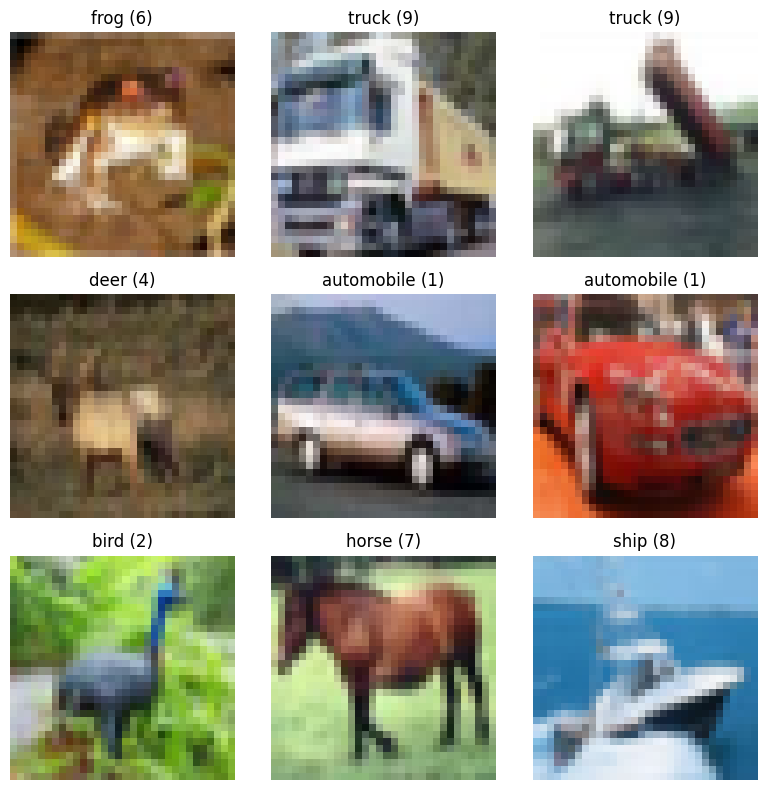

In [2]:
# Q2: Show 3x3 grid of first 9 training images
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(xTrain[i])
    plt.title(f'{classNames[yTrain[i][0]]} ({yTrain[i][0]})')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
def preprocessFn(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.per_image_standardization(image)
    return image, label

batchSize = 256

xTrainDs = tf.data.Dataset.from_tensor_slices(xTrain)
yTrainDs = tf.data.Dataset.from_tensor_slices(yTrain)
trainDs = tf.data.Dataset.zip((xTrainDs, yTrainDs))
trainDs = trainDs.map(preprocessFn).shuffle(1000).batch(batchSize).repeat()

xTestDs = tf.data.Dataset.from_tensor_slices(xTest)
yTestDs = tf.data.Dataset.from_tensor_slices(yTest)
testDs = tf.data.Dataset.zip((xTestDs, yTestDs))
testDs = testDs.map(preprocessFn).batch(batchSize)

print("Baseline tf.data pipelines created")

Baseline tf.data pipelines created


In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

stepsPerEpoch = 50000 // batchSize
validationSteps = 10000 // batchSize

print("Training baseline model...")
historyBaseline = model.fit(
    trainDs,
    epochs=5,
    steps_per_epoch=stepsPerEpoch,
    validation_data=testDs,
    validation_steps=validationSteps,
    verbose=1
)

baselineValAcc = historyBaseline.history['val_sparse_categorical_accuracy'][-1]
print(f"Baseline validation accuracy: {baselineValAcc:.4f}")

Training baseline model...
Epoch 1/5


C:\Users\natsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 1.4815 - sparse_categorical_accuracy: 0.4705 - val_loss: 1.4830 - val_sparse_categorical_accuracy: 0.4579
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 1.1047 - sparse_categorical_accuracy: 0.6088 - val_loss: 1.0956 - val_sparse_categorical_accuracy: 0.6096
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.9371 - sparse_categorical_accuracy: 0.6708 - val_loss: 0.9890 - val_sparse_categorical_accuracy: 0.6547
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.8335 - sparse_categorical_accuracy: 0.7079 - val_loss: 0.9142 - val_sparse_categorical_accuracy: 0.6834
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.7538 - sparse_categorical_accuracy: 0.7367 - val_loss: 0.9830 - val_sparse_categorical_accuracy: 0.6682
Baseline validation accuracy: 0.6682


In [5]:
def preprocessNewFn(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.per_image_standardization(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

trainDsAug = tf.data.Dataset.zip((xTrainDs, yTrainDs))
trainDsAug = trainDsAug.map(preprocessNewFn).shuffle(1000).batch(batchSize).repeat()

modelAug = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10)
])

modelAug.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

print("Training augmented model...")
historyAug = modelAug.fit(
    trainDsAug,
    epochs=5,
    steps_per_epoch=stepsPerEpoch,
    validation_data=testDs,
    validation_steps=validationSteps,
    verbose=1
)

augValAcc = historyAug.history['val_sparse_categorical_accuracy'][-1]
delta = augValAcc - baselineValAcc
print(f"Augmented validation accuracy: {augValAcc:.4f}")
print(f"Improvement delta: {delta:.4f} (~expected +≈4%)")

Training augmented model...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 1.4774 - sparse_categorical_accuracy: 0.4723 - val_loss: 1.3861 - val_sparse_categorical_accuracy: 0.5162
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.1040 - sparse_categorical_accuracy: 0.6086 - val_loss: 1.0927 - val_sparse_categorical_accuracy: 0.6114
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.9505 - sparse_categorical_accuracy: 0.6630 - val_loss: 0.9592 - val_sparse_categorical_accuracy: 0.6633
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.8620 - sparse_categorical_accuracy: 0.6964 - val_loss: 0.9164 - val_sparse_categorical_accuracy: 0.6769
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.7983 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.8379 - val_sparse_categorical_accuracy: 0.7064
Augmented validation accuracy: 0.7064
Improvement delta: 0.0383 (~expected +≈4%)


In [6]:
testSubset = testDs.take(2)
testImagesSubset = []
testLabelsSubset = []

for batch in testSubset:
    images, labels = batch
    testImagesSubset.append(images.numpy())
    testLabelsSubset.append(labels.numpy())

testImagesSubset = np.concatenate(testImagesSubset)
testLabelsSubset = np.concatenate(testLabelsSubset).flatten()

predictions = modelAug.predict(testImagesSubset, verbose=0)
predictedClasses = np.argmax(predictions, axis=1)

subsetAcc = np.mean(predictedClasses == testLabelsSubset)
print(f"Accuracy on 512 test subset: {subsetAcc:.4f}")

confusionMatrix = tf.math.confusion_matrix(testLabelsSubset, predictedClasses, num_classes=10)

print("10x10 Confusion Matrix:")
print(confusionMatrix.numpy())

Accuracy on 512 test subset: 0.6777
10x10 Confusion Matrix:
[[32  0  7  1  1  0  1  2 11  2]
 [ 1 27  0  1  0  0  0  2  4  6]
 [ 4  0 30  3  3  6  3  2  0  0]
 [ 1  1  2 27  2 11  2  2  0  1]
 [ 3  1  8  3 21  4  1  3  0  0]
 [ 0  0  3  8  3 32  0  4  0  0]
 [ 0  0  5  4  2  1 44  0  0  0]
 [ 0  0  0  2  2  4  0 38  1  1]
 [ 5  0  0  2  0  0  0  0 50  0]
 [ 2  4  0  0  0  0  0  3  4 46]]
